In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
import astropy

from astropy.io import fits
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

save_path = '/Users/labuser/Desktop/'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
filename = "/Users/labuser/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits" 
hdu_list = fits.open(filename) 
hdu_list.info() 
image_data = hdu_list[0].data

Filename: /Users/labuser/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


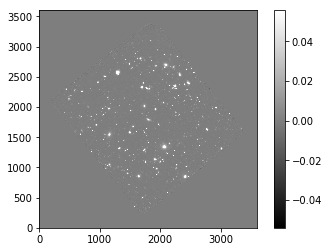

In [3]:
image_data = hdu_list[0].data

m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation = 'nearest', cmap='gray', vmin = m-s, vmax = m+s, origin='lower')
plt.colorbar()

#plt.savefig(save_path + 'raw_image.png', dpi = 600)

# Background subtraction

In [4]:
#Input array with dtype '>f4' has non-native byte order. Only native byte order arrays are supported. To change the byte order of the array 'data'
image_data = image_data.byteswap().newbyteorder()


bkg = sep.Background(image_data)
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)

print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


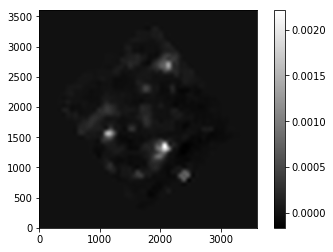

In [5]:
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();

#plt.savefig(save_path + 'background.png', dpi = 600)

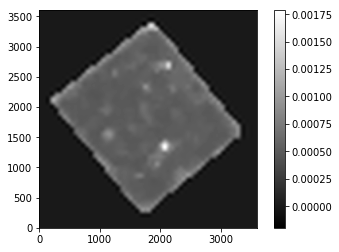

In [6]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();

#plt.savefig(save_path + 'background_noise.png', dpi = 600)

In [7]:
# subtract the background
data_sub = image_data - bkg

# Object detection

In [8]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

len(objects)

8640

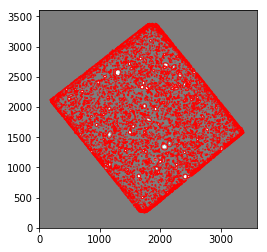

In [9]:
from matplotlib.patches import Ellipse    #Ellipse fitting

#plot bagkround_subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = 'nearest', cmap = 'gray', vmin = m - s, vmax = m + s, origin = 'lower')

#plot an ellipse for each object
#objects['x'] and objects['y'] will give the centroid coordinates of the objects.
for i in range(len(objects)):
    e = Ellipse(xy = (objects['x'][i], objects['y'][i]), width = 6*objects['a'][i], height = 6*objects['b'][i], angle = objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')   #leaves the center of the ellipse clear
    e.set_edgecolor('red')    #outlines the ellipse with a specified color
    ax.add_artist(e)          #add the ellipse to the image

#Save the background at a high resolution.
plt.savefig(save_path + 'f105w_sources_detection.png', dpi = 600)

# Aperture photometry

In [10]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err = bkg.globalrms, gain = 1.0)

In [11]:
for i in range(len(objects)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i + 1, flux[i], fluxerr[i]))

object 1: flux = 0.031282 +/- 0.176890
object 2: flux = 0.031018 +/- 0.176142
object 3: flux = -0.024388 +/- 0.002883
object 4: flux = 0.001947 +/- 0.044219
object 5: flux = 0.012457 +/- 0.111649
object 6: flux = -0.011228 +/- 0.002875
object 7: flux = 0.029368 +/- 0.171394
object 8: flux = -0.009126 +/- 0.002875
object 9: flux = 0.048023 +/- 0.219161
object 10: flux = 0.027840 +/- 0.166877
object 11: flux = 0.104682 +/- 0.323559
object 12: flux = 0.044953 +/- 0.212041
object 13: flux = 0.014043 +/- 0.118538
object 14: flux = 0.010265 +/- 0.101357
object 15: flux = 0.011400 +/- 0.106811
object 16: flux = 0.025562 +/- 0.159908
object 17: flux = 0.016498 +/- 0.128478
object 18: flux = -0.008420 +/- 0.002875
object 19: flux = 0.006981 +/- 0.083599
object 20: flux = 0.014791 +/- 0.121653
object 21: flux = -0.002137 +/- 0.002863
object 22: flux = 0.057425 +/- 0.239652
object 23: flux = -0.006278 +/- 0.002863
object 24: flux = 0.034407 +/- 0.185514
object 25: flux = 0.031591 +/- 0.177761
obj

object 1911: flux = 0.078298 +/- 0.279832
object 1912: flux = 0.069610 +/- 0.263853
object 1913: flux = 0.044228 +/- 0.210323
object 1914: flux = 0.032791 +/- 0.181106
object 1915: flux = 0.014722 +/- 0.121368
object 1916: flux = 0.050210 +/- 0.224094
object 1917: flux = 0.017934 +/- 0.133948
object 1918: flux = 0.024411 +/- 0.156266
object 1919: flux = 0.603830 +/- 0.777071
object 1920: flux = 0.079884 +/- 0.282652
object 1921: flux = 0.297798 +/- 0.545717
object 1922: flux = 0.043910 +/- 0.209566
object 1923: flux = 0.313223 +/- 0.559670
object 1924: flux = 0.019086 +/- 0.138183
object 1925: flux = 0.014770 +/- 0.121566
object 1926: flux = 0.391252 +/- 0.625508
object 1927: flux = 0.283013 +/- 0.531997
object 1928: flux = 0.013072 +/- 0.114368
object 1929: flux = 0.061623 +/- 0.248256
object 1930: flux = 0.030225 +/- 0.173876
object 1931: flux = 1.741216 +/- 1.319554
object 1932: flux = 0.058192 +/- 0.241248
object 1933: flux = 0.660976 +/- 0.813009
object 1934: flux = 0.724160 +/- 0

object 3745: flux = 0.074555 +/- 0.273063
object 3746: flux = 0.001535 +/- 0.039289
object 3747: flux = 0.027344 +/- 0.165384
object 3748: flux = 0.231148 +/- 0.480788
object 3749: flux = 0.183796 +/- 0.428724
object 3750: flux = 0.029945 +/- 0.173069
object 3751: flux = 0.019069 +/- 0.138121
object 3752: flux = 0.032940 +/- 0.181516
object 3753: flux = 0.039589 +/- 0.198990
object 3754: flux = 0.057555 +/- 0.239922
object 3755: flux = 1.142732 +/- 1.068990
object 3756: flux = 0.042776 +/- 0.206843
object 3757: flux = 1.129091 +/- 1.062591
object 3758: flux = 0.015884 +/- 0.126065
object 3759: flux = 0.021172 +/- 0.145536
object 3760: flux = 0.074028 +/- 0.272096
object 3761: flux = 0.133701 +/- 0.365663
object 3762: flux = 0.019414 +/- 0.139364
object 3763: flux = 0.020799 +/- 0.144248
object 3764: flux = 0.012277 +/- 0.110839
object 3765: flux = 0.017532 +/- 0.132441
object 3766: flux = 0.021002 +/- 0.144947
object 3767: flux = 0.011549 +/- 0.107507
object 3768: flux = 0.065249 +/- 0

object 5410: flux = 0.010156 +/- 0.100819
object 5411: flux = 0.144244 +/- 0.379805
object 5412: flux = 0.024831 +/- 0.157606
object 5413: flux = 0.035443 +/- 0.188284
object 5414: flux = 0.217455 +/- 0.466330
object 5415: flux = 0.019870 +/- 0.140991
object 5416: flux = 0.068883 +/- 0.262471
object 5417: flux = 0.016542 +/- 0.128648
object 5418: flux = 0.068259 +/- 0.261280
object 5419: flux = 0.019271 +/- 0.138849
object 5420: flux = 0.017497 +/- 0.132306
object 5421: flux = 0.020000 +/- 0.141452
object 5422: flux = 0.019358 +/- 0.139163
object 5423: flux = -0.005685 +/- 0.002871
object 5424: flux = 0.050915 +/- 0.225662
object 5425: flux = 0.078217 +/- 0.279688
object 5426: flux = 0.036677 +/- 0.191533
object 5427: flux = 1.791999 +/- 1.338659
object 5428: flux = 0.636138 +/- 0.797588
object 5429: flux = 0.630009 +/- 0.793736
object 5430: flux = 0.004509 +/- 0.067211
object 5431: flux = 0.014188 +/- 0.119147
object 5432: flux = 0.030365 +/- 0.174280
object 5433: flux = 0.010718 +/- 

object 7410: flux = 0.074523 +/- 0.273004
object 7411: flux = 0.112890 +/- 0.336003
object 7412: flux = 0.037393 +/- 0.193394
object 7413: flux = 0.027165 +/- 0.164843
object 7414: flux = 0.031136 +/- 0.176476
object 7415: flux = 0.010417 +/- 0.102102
object 7416: flux = 0.029428 +/- 0.171569
object 7417: flux = 0.073490 +/- 0.271106
object 7418: flux = 0.014593 +/- 0.120836
object 7419: flux = 0.017544 +/- 0.132485
object 7420: flux = 0.041701 +/- 0.204229
object 7421: flux = 0.015781 +/- 0.125654
object 7422: flux = 0.009479 +/- 0.097402
object 7423: flux = 0.044126 +/- 0.210083
object 7424: flux = 0.037489 +/- 0.193643
object 7425: flux = 0.020794 +/- 0.144229
object 7426: flux = 0.010468 +/- 0.102353
object 7427: flux = 0.020074 +/- 0.141713
object 7428: flux = 0.035860 +/- 0.189390
object 7429: flux = -0.001315 +/- 0.002875
object 7430: flux = 0.016969 +/- 0.130297
object 7431: flux = 0.010249 +/- 0.101277
object 7432: flux = 0.024071 +/- 0.155176
object 7433: flux = -0.002961 +/-

# Convert to AB Magnitude

In [18]:
AB_mag = [0] * len(objects)
for nmbr in range(len(objects)):
    
    AB_mag[nmbr]= -2.5*np.log10(flux[nmbr]) - 48.60
    print(AB_mag[nmbr])

-44.83823511664862
-44.82903065476491
nan
-41.82344564912445
-43.83855552736659
nan
-44.76966896302525
nan
-45.303627843777434
-44.71166100995388
-46.149680435239375
-45.231900896460196
-43.96864872249311
-43.62840024142465
-43.74229824453096
-44.619003700697554
-44.14359942307319
nan
-43.20971808324522
-44.02501376798759
nan
-45.497746194778394
nan
-44.94162532354648
-44.8489044194383
-44.24486230867515
-44.544578549562665
-44.78059670024806
-45.22790793361728
-44.885297005992825
-45.17107396060349
-42.18562302838822
-42.89834115854326
-44.54765134998517
-45.23076648047082
-43.548595962696275
-43.76141983484771
-44.92843473679709
-43.3485094648201
nan
nan
-44.28357465371344
-44.06796360390782
nan
-45.01825297013672
nan
-41.21002868934127
-42.930819491437774
-43.14753921689703
-43.928621541729385
-44.824112320148885
-45.001726607584175
-45.62186763205427
-45.71898002810303
-44.79925037262581
-45.5988751134707
-45.30591019062521
-44.70260623542203
-45.04757635462185
-44.69007594844517
-

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.



-44.68187341841324
-45.74308253513876
-44.55988619722271
-43.76389484507395
-44.035854670356656
-44.04713102162209
-45.308772655934476
-43.0521987224085
-43.99157995853205
-41.36827766166074
-47.40228104531994
-47.54041455195503
-50.68555133236915
-55.8675837278852
-49.88954613310937
-50.64592182475859
-46.375028564526005
-44.60978757658983
-46.22225045250296
-45.59161608396221
-44.66512831982828
-44.33091702866011
-46.49626898224955
-44.558310853747216
-47.33763243670223
-44.52980533468683
-44.2118920926096
-44.32989336912206
-45.16601065311664
-46.42038662631041
-43.861168050592916
-44.75424878107616
-44.562427291266715
-43.90276156545618
-43.876833182873185
-44.30668589186666
-43.97929313826373
-44.45834564372706
-44.63376169256942
-44.48931749505451
-44.66585290471714
-45.08441940210831
-44.80888080233539
-46.86204969030987
-45.14007627683174
-45.094227748540746
-44.66478361246962
-46.21490231887351
-44.929717341624446
-44.55154705834946
-44.60275137470916
-44.626182531777864
-45.

-44.836914515726406
-45.18738287174602
-45.10681449198862
-44.57816944504174
-44.1119685244997
-44.98724900015683
-46.075399794110126
-48.067824605521096
-46.39292067984152
-44.38752063598349
-44.76601570066359
-44.7539834466919
-44.79542397899041
-44.97057333733214
-45.39501239216784
-44.917642139314104
-44.40556885411464
-43.766030110165616
-44.761031318250154
-44.11944629183762
-44.88301601089585
-44.87213929563903
-45.78731985185669
-47.07735295969356
-44.675359369061646
-44.86950184060226
-44.46971883717604
-44.94854140288298
-44.36528596465762
-44.57469575737037
-42.87343379510538
-44.850277907554286
-48.439082764209275
-44.55536886569927
-44.5738416951231
-45.18376409244209
-44.94291617863652
-45.416003255623984
-45.937886854751945
-44.54213372981764
-44.72995865247751
-45.23201282714814
-45.10348764037024
-44.44518564350287
-44.42259824348652
-44.60194253949151
-44.16689018702395
-44.052740465928146
-45.161719518665
-47.00383822935088
-45.56593820710302
-43.76453442728515
-47.7

-43.81577564579711
-44.16820801442455
-46.29076623616756
-45.340395746092625
-44.454863311577505
-47.00205011206528
-43.89488714013366
-45.11731336827678
-44.74481093419751
-44.9623295109991
-46.604982714335726
-44.72684032715681
-46.269195675833345
-49.040568269176916
-44.826302283527546
nan
-46.58533914013147
-46.88994510930717
-44.61201462444162
-44.91236137822088
-45.435017672061576
-45.582047715495854
-44.52964201845027
-44.2946695050207
-44.6344419423942
-44.58351487777007
-44.81287665396084
-47.463973724866406
-44.34475595279013
-45.73551951009504
-45.6369672560541
-48.121268273204
-47.02536645964863
-45.95484131810378
-43.08086463737957
-44.991328917203006
-44.37904205031975
-44.661508506093725
-45.65206310798177
-43.350787514185214
-45.14354972476508
-44.7644711411254
-45.79653632616998
-45.803600640537624
-43.234116443122126
-46.05622258591315
-45.04844601560303
-43.6476920785068
-46.85077653679526
-44.43408038170691
nan
-44.809912836980345
-40.42205042454449
-47.608245920282

-45.75989903448527
-43.84048183134912
-43.72288824093798
-44.34828879117274
-44.203872294755925
-43.25084305790151
-45.92577690551452
-44.780281666870906
-41.57973827198015
-44.428189893102854
-44.24640540582657
-44.27830616710901
-44.41251353121571
-44.15439223913082
-44.658079384906976
-46.209254117786216
-45.33450680991037
-43.8960450366046
-44.47019607338814
-43.50970201763454
-44.35050142870522
-43.44333627070467
-43.19911469857921
-44.909859509815604
-43.59701795456013
-46.14246418498565
-44.578625709584976
-43.054264978805975
-43.31854580004139
-43.54362633714272
-45.004860148096064
-45.40970477507178
-45.03094629265773
-44.71065925355941
-47.28070682177467
-44.01145349572576
nan
-44.98812819401694
-44.41017488198579
-45.36835493102824
-44.64685652230218
-47.19804076889265
-48.444042865771905
-43.793629732869526
-41.50165742634852
-43.91078065357422
-44.62680517482769
-44.61908477202042
-45.150819987309745
-44.55999365139363
-47.40868190609481
-47.15697750791141
-46.435947877149

# Histogram

In [ ]:
histogram = plt.hist(AB_mag, bins=len(AB_mag))
plt.xlim(-55,-35)
plt.ylim(0,15)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0, 15)